<a href="https://colab.research.google.com/github/Kim-Jeong-Ju/AI_Modeling/blob/main/Semantic_Segmentation_in_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Drive Connection and Packages Importation**

In [8]:
from google.colab import drive
drive.mount('/content/drive')

import os
import time
import random

import numpy as np
import pandas as pd
import seaborn as sn

import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import datasets, transforms
import torchvision.models as models 

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"
device

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'cuda'

# **Semantic Segmentation, 의미론적 분할**  


---





## **PennFudan Dataset Preparation and PreProcessing**  
보행자 Detection과 Segmentation을 위한 Dataset. 170개의 Image와 345명의 labeled된 보행자 데이터 존재. University of Pennsylvania와 Fudan University에서 수집한 데이터셋

/content/drive/MyDrive/Colab Notebooks/AI Algorithm Modeling/data



[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


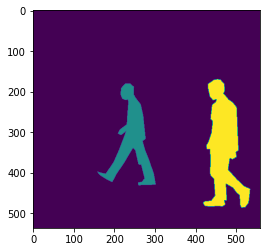

In [9]:
# Setting Directory path
root = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "AI Algorithm Modeling", "data")
print(root)
print()


# Get Sample Image of PennFudan and Plot
sample_img = Image.open(os.path.join(root, "PennFudanPed/PNGImages/FudanPed00001.png"))
plt.imshow(sample_img)
print()

sample_mask = Image.open(os.path.join(root, "PennFudanPed/PedMasks/FudanPed00001_mask.png"))
plt.imshow(sample_mask)
print()

print(np.array(sample_mask))

In [10]:
## Definition of PennFudan Datset for Object Detection and Semantic Segmentation

class SSDataset(Dataset):
    def __init__(self, root, transforms=None, mode="detection"):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

        self.mode = mode
        if not (self.mode == "detection" or self.mode == "segmentation"):
            raise ValueError(f"Inputted Mode {self.mode} is not supported.")
    
    def __getitem__(self, idx):                                                 # Image and Mask Importation
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        mask = np.array(mask)

        if self.mode == "detection":                                            # mode = Object Detection인 경우
            obj_ids = np.unique(mask)
            obj_ids = obj_ids[1:]                                               # 0 값은 Background이므로 제거
            masks = mask == obj_ids[:, None, None]                              # 각 object id 별로 mask를 따로 만들어줌 & slicing 속성으로 None 입력하면 해당 axis를 기준으로 차원 증가
            num_objs = len(obj_ids)

            boxes = []                                                          # object 별 mask 의 가장자리 위치를 기준으로 Bounding Box 를 만듦
            for i in range(num_objs):
                pos = np.where(masks[i])
                xmin = np.min(pos[1])
                xmax = np.min(pos[1])
                ymin = np.min(pos[0])
                ymax = np.min(pos[0])
                boxes.append([xmin, ymin, xmax, ymax])

            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.ones((num_objs,), dtype=torch.int64)

            img_id = torch.tensor([idx])
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

            target = {}
            target["boxes"] = boxes
            target["labels"] = labels
            target["img_id"] = img_id
            target["area"] = area
            target["iscrowd"] = iscrowd

            if self.transforms is not None:
                img, target = self.transforms(img, target)
            
            return img, target
        
        elif self.mode == "segmentation":                                       # mode = Semantic Segmentation인 경우
            mask[mask > 0] = 1                                                  # object 가 있는 부분은 전부 1로 mask value 수정 -> 다 같은 Pedestrian class label
            mask = torch.as_tensor(mask, dtype=torch.uint8)
            img_id = torch.tensor([idx])

            target = {}
            target["masks"] = mask
            target["img_id"] = img_id
            
            if self.transforms is not None:
                img, target = self.transforms(img, target)
            
            return img, target
    
    def __len__(self):
        return len(self.imgs)


## Definition of Transforms for Data Pre-Processing

class ToTensor(object):
    def __call__(self, img, target):
        img = transforms.ToTensor()(img)
        return img, target

class RandomHorizontalFlip(object):
    def __init__(self, prob):
        self.prob = prob
    
    def __call__(self, img, target):
        if random.random() < self.prob:
            height, width = img.shape[-2:]
            img = img.flip(-1)

            if "boxes" in target:
                box = target["boxes"]
                box[:, [0, 2]] = width - box[:, [2, 0]]
                target["boxes"] = box
            
            if "masks" in target:
                target["masks"] = target["masks"].flip(-1)
            
            if "keypoints" in target:
                keypoints = target["keypoints"]
                keypoints = _flip_coco_person_keypoints(keypoints, width)
                target["keypoints"] = keypoints
        
        return img, target

class Resize(object):
    def __init__(self, size):
        self.size = size
    
    def __call__(self, img, target):
        img = transforms.Resize(self.size)(img)

        if "masks" in target:
            target["masks"] = transforms.Resize(self.size)(target["masks"].unsqueeze(dim=0)).squeeze()
        
        return img, target

class Normalize(object):
    def __call__(self, img, target):
        img = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(img)
        return img, target

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms
    
    def __call__(self, img, target):
        for tf in self.transforms:
            img, target = tf(img, target)
        return img, target

def apply_transform(is_train):
    transforms = [ToTensor(), Resize((300, 300)), Normalize()]
    if is_train:
        transforms.append(RandomHorizontalFlip(0.5))
    return Compose(transforms)

ss_dataset = SSDataset(os.path.join(root, "PennFudanPed"), transforms=apply_transform(is_train=True), mode="segmentation")

random_seed = 0
torch.manual_seed(random_seed)

valid_size = int(len(ss_dataset) * 0.2)
train_size = len(ss_dataset) - valid_size

train_data, valid_data = random_split(ss_dataset, [train_size, valid_size])
print(len(train_data), len(valid_data))

train_loader = DataLoader(train_data, batch_size=2, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=2, shuffle=False, drop_last=True)

136 34


## **대표적인 Pretrained Semantic Segmentation Model**

### **① FCN(Fully-Convolutional Network) --- PASCAL VOC 2012 mean-IoU = 62.7%**  
- CNN을 활용한 대표적인 Semantic Segmentation Model, Fully-Connected Layer 없이 **Conv Layer로만 구성된 Mode**l => Input size에 제약 X
- **VGG16을 Backbone Network**로 가져와 Transfer Learning(Fine-Tuning) 수행  
> *VGG16의 FC Layer를 Conv Layer로 변환하여, 512 X 7 X 7 matrix => 4096 X 1 X 1 matrix로 vector 형식의 matrix feature map으로 변환*  
- **Output Class 갯수의 channel로 encoding**된 feature를 **Bilinear Interpolation**을 통해 원본 Image size로 **Upsampling** 수행
- Upsampling 시 Coarse한 정보(1/32 크기)만 담기는 문제를 피하기 위해, **중간의 Conv Layer를 거친 feature map들을 사용**하여 detail 추가  
  
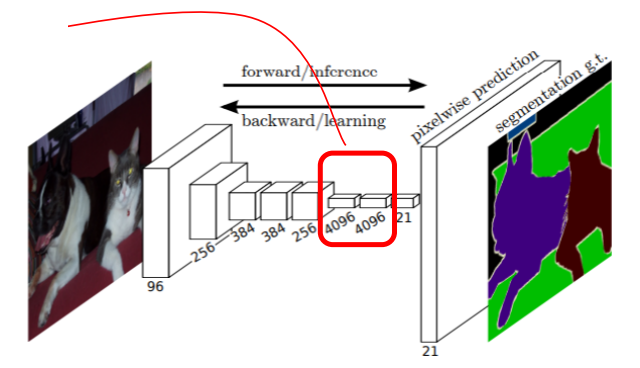  
  
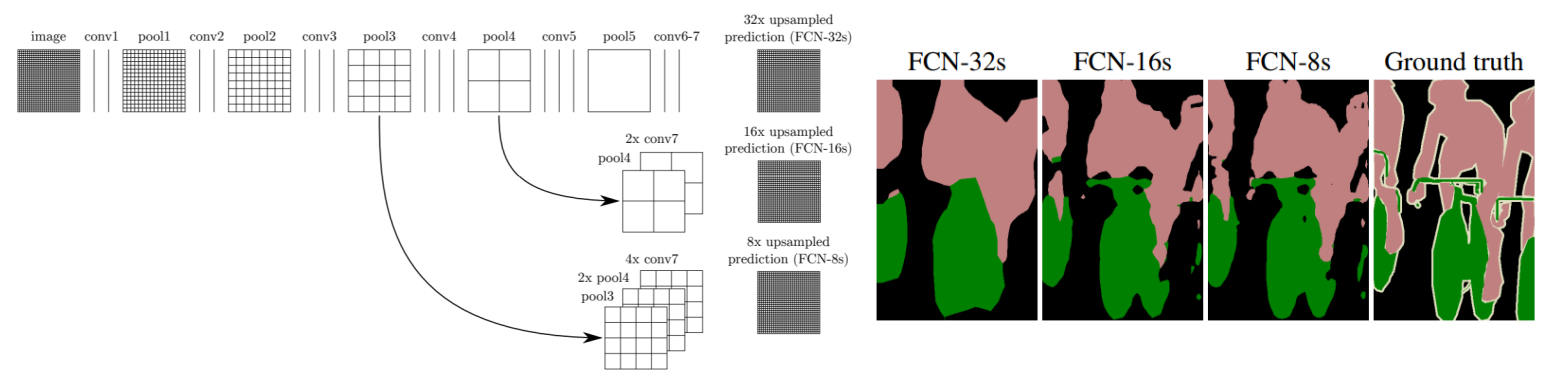



In [11]:
## ① FCN Importation and Fine-Tuning
fcn = models.segmentation.fcn_resnet50(pretrained=True)
fcn.classifier[4] = nn.Conv2d(512, 2, kernel_size=1, stride=1)
fcn

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


  0%|          | 0.00/135M [00:00<?, ?B/s]

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

### **② DeepLab --- PASCAL VOC 2012 mean-IoU = 86.9%**  
- **Atrous Convolution 사용 :** Conv filter의 **Dilation을 확장**하여 ResNet Backbone Network에서 Convolution 연산 수행 => **넓은 Receptive Field를 가짐 & Pooling 대신 사용 시 spatial 정보의 손실 방지**
- **ASPP(Atrous Spatial Pyramid Pooling) 사용 :** **Atrous rate가 다른 여러 filter를 사용**하여 **Multi-Scale한 정보** 획득  
  
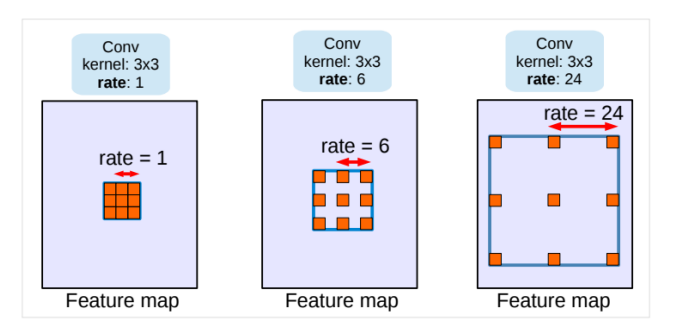  
  
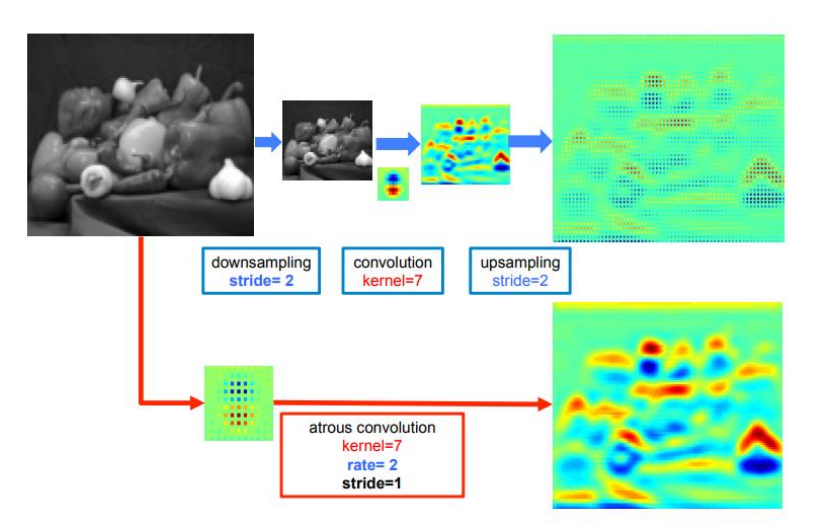  
  
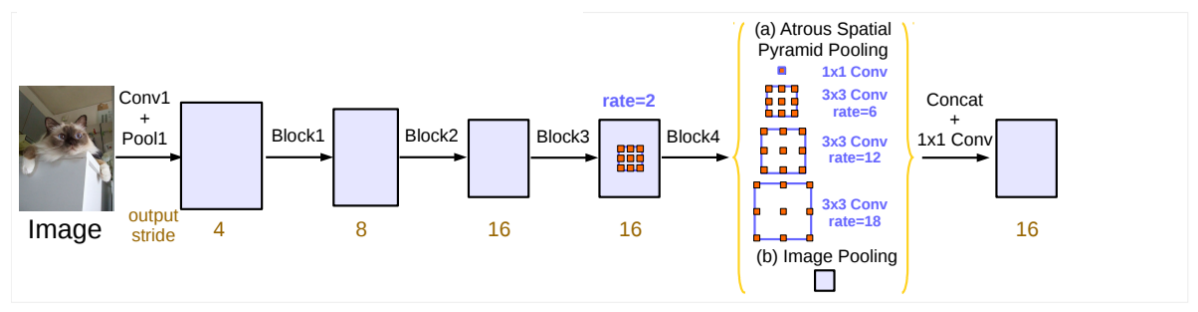

In [13]:
## ② DeepLab Importation and Fine-Tuning
deeplab = models.segmentation.deeplabv3_resnet50(pretrained=True)
deeplab.classifier[4] = nn.Conv2d(256, 2, kernel_size=1, stride=1)
deeplab

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

## **Trainer Class Definition**

In [15]:
class Sem_Seg_Trainer(nn.Module):
    def __init__(self, model, opt="adam", lr=0.001, has_scheduler=False, device="cuda"):
        super().__init__()

        self.model = model
        self.loss = nn.CrossEntropyLoss()

        self._get_optimizer(opt=opt.lower(), lr=lr)
        self.has_scheduler = has_scheduler
        if self.has_scheduler:
            self._get_scheduler()
        
        self.device = device
    
    def _get_optimizer(self, opt, lr=0.001):
        if opt == "sgd":
            self.optimizer = torch.optim.SGD(params=self.model.parameters(), lr=lr)
        elif opt == "adagrad":
            self.optimizer = torch.optim.Adagrad(params=self.model.parameters(), lr=lr)
        elif opt == "adadelta":
            self.optimizer = torch.optim.Adadelta(params=self.model.parameters(), lr=lr)
        elif opt == "rmsprop":
            self.optimizer = torch.optim.RMSprop(params=self.model.parameters(), lr=lr)
        elif opt == "adam":
            self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=lr)
        else:
            raise ValueError(f"Inputted Optimizer {opt} is not Supported")
    
    def _get_scheduler(self):
        # self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer=self.optimizer, step_size=5, gamma=0.5, verbose=True)
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=self.optimizer, lr_lambda=lambda epoch: 0.95**epoch)
    
    def train(self, train_loader, valid_loader, max_epochs=10, disp_epochs=1):
        print("========== Train Start ==========")
        start_time = time.time()

        history = {"Train Loss" : [], "Valid Loss" : []}
        for epoch in range(max_epochs):
            train_loss = self._train_epoch(train_loader)
            valid_loss = self._valid_epoch(valid_loader)

            history["Train Loss"].append(train_loss)
            history["Valid Loss"].append(valid_loss)

            if self.has_scheduler:
                self.scheduler.step()
            
            if epoch % disp_epochs == 0:
                print(f"{epoch}/{max_epochs} Epoch ==> Train Loss : {train_loss:>6f}, Valid Loss : {valid_loss:>6f}, Time : {time.time() - start_time:>3f}")
        
        self.plot_history(history)
    
    def _train_epoch(self, train_loader):
        train_epoch_loss = 0
        self.model.train()

        for (x, y) in train_loader:
            x = x.to(self.device)
            label = y["masks"].to(self.device).type(torch.long)

            out = self.model(x)
            loss = self.loss(out["out"], label)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            train_epoch_loss += loss.to("cpu").item()
        
        train_epoch_loss /= len(train_loader)
        return train_epoch_loss
    
    def _valid_epoch(self, valid_loader):
        valid_epoch_loss = 0
        self.model.eval()

        for (x, y) in valid_loader:
            x = x.to(self.device)
            label = y["masks"].to(self.device).type(torch.long)

            out = self.model(x)
            loss = self.loss(out["out"], label)

            valid_epoch_loss += loss.to("cpu").item()
        
        valid_epoch_loss /= len(valid_loader)
        return valid_epoch_loss
    
    def plot_history(self, history):
        fig = plt.figure(figsize=(10, 10))

        plt.plot(history["Train Loss"], color="red", label="Train Loss")
        plt.plot(history["Valid Loss"], color="orange", label="Valid Loss")
        plt.title("Loss")
        plt.legend()

        fig.show()
    
    def test(self, test_loader):
        print("========== Test Start ==========")
        start_time = time.time()

        test_loss = 0
        self.model.eval()

        for (x, y) in test_loader:
            x = x.to(self.device)
            label = y["masks"].to(self.device).type(torch.long)

            out = self.model(x)
            loss = self.loss(out["out"], label)

            test_loss += loss.to("cpu").item()
        
        test_loss /= len(test_loader)
        print(f"Test Loss : {test_loss:>6f}, Time : {time.time() - start_time:>3f}")

## **Training + Validation + Test Semantic Segmentation Model**

========== Train Start ==========
0/10 Epoch ==> Train Loss : 0.268977, Valid Loss : 0.247405, Time : 135.789666
1/10 Epoch ==> Train Loss : 0.190303, Valid Loss : 0.171322, Time : 152.202346
2/10 Epoch ==> Train Loss : 0.151692, Valid Loss : 0.181716, Time : 168.735461
3/10 Epoch ==> Train Loss : 0.148903, Valid Loss : 0.146218, Time : 185.451274
4/10 Epoch ==> Train Loss : 0.132901, Valid Loss : 0.141155, Time : 202.299396
5/10 Epoch ==> Train Loss : 0.121226, Valid Loss : 0.140057, Time : 219.285294
6/10 Epoch ==> Train Loss : 0.113622, Valid Loss : 0.202026, Time : 236.338758
7/10 Epoch ==> Train Loss : 0.130982, Valid Loss : 0.164259, Time : 253.344157
8/10 Epoch ==> Train Loss : 0.100562, Valid Loss : 0.129985, Time : 270.325247
9/10 Epoch ==> Train Loss : 0.089676, Valid Loss : 0.187716, Time : 287.315005
Total Training Time : 287.331716


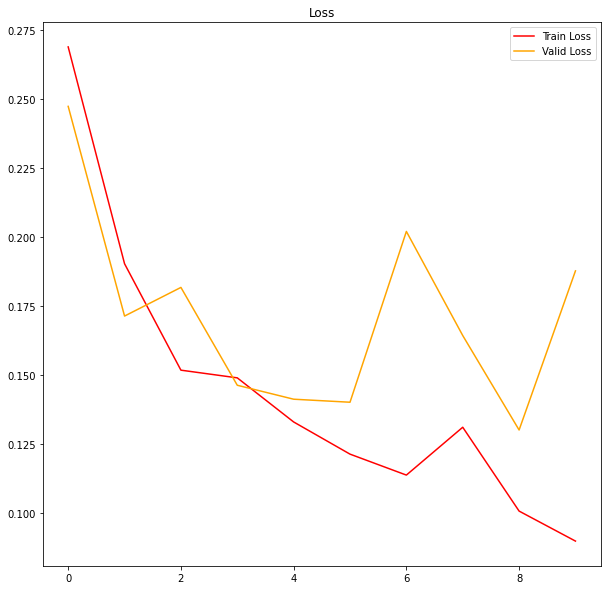

In [16]:
## Training + Validation for FCN Model

device = "cuda"

fcn_trainer = Sem_Seg_Trainer(model=fcn, opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)
start_time = time.time()
fcn_trainer.train(train_loader, valid_loader, max_epochs=10, disp_epochs=1)
print(f"Total Training Time : {time.time() - start_time:>3f}")

torch.Size([1, 2, 536, 559])



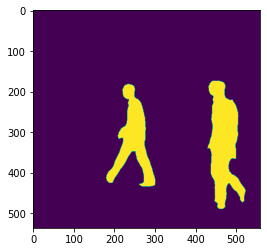

In [17]:
## Test Sample Image Data for FCN Model

fcn_img = Image.open(os.path.join(root, "PennFudanPed/PNGImages/FudanPed00001.png"))
fcn_mask = Image.open(os.path.join(root, "PennFudanPed/PedMasks/FudanPed00001_mask.png"))

infer_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
fcn_input = infer_transform(fcn_img).to(device)
fcn_output = fcn(fcn_input.unsqueeze(dim=0))
print(fcn_output["out"].shape)
print()

fcn_class_label = torch.argmax(fcn_output["out"][0].to("cpu"), dim=0).numpy()
fcn_result = np.zeros_like(fcn_class_label)
fcn_result[fcn_class_label == 1] = 1
plt.imshow(fcn_result)

========== Train Start ==========
0/10 Epoch ==> Train Loss : 0.296695, Valid Loss : 0.361956, Time : 21.021597
1/10 Epoch ==> Train Loss : 0.195327, Valid Loss : 0.171778, Time : 42.590671
2/10 Epoch ==> Train Loss : 0.162761, Valid Loss : 0.156613, Time : 64.250518
3/10 Epoch ==> Train Loss : 0.140465, Valid Loss : 0.163162, Time : 85.471997
4/10 Epoch ==> Train Loss : 0.127840, Valid Loss : 0.158621, Time : 106.620128
5/10 Epoch ==> Train Loss : 0.105408, Valid Loss : 0.131907, Time : 128.013595
6/10 Epoch ==> Train Loss : 0.114404, Valid Loss : 0.278484, Time : 148.978060
7/10 Epoch ==> Train Loss : 0.130708, Valid Loss : 0.152458, Time : 170.047536
8/10 Epoch ==> Train Loss : 0.105231, Valid Loss : 0.126786, Time : 191.121827
9/10 Epoch ==> Train Loss : 0.098165, Valid Loss : 0.209021, Time : 212.160028
Total Training Time : 212.175390


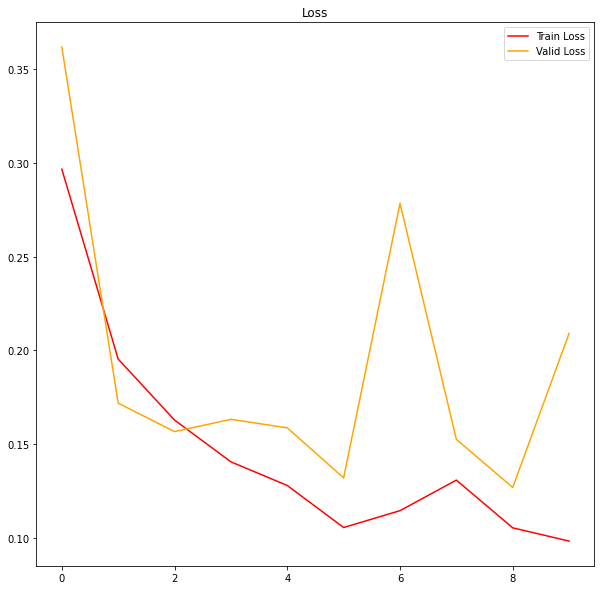

In [18]:
## Training + Validation for DeepLab Model

device = "cuda"

deeplab_trainer = Sem_Seg_Trainer(model=deeplab, opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)
start_time = time.time()
deeplab_trainer.train(train_loader, valid_loader, max_epochs=10, disp_epochs=1)
print(f"Total Training Time : {time.time() - start_time:>3f}")

torch.Size([1, 2, 536, 559])



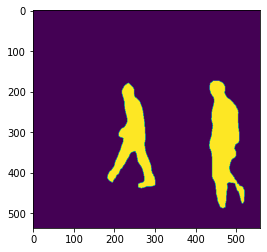

In [19]:
## Test Sample Image Data for Deeplab Model

deeplab_img = Image.open(os.path.join(root, "PennFudanPed/PNGImages/FudanPed00001.png"))
deeplab_mask = Image.open(os.path.join(root, "PennFudanPed/PedMasks/FudanPed00001_mask.png"))

infer_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
deeplab_input = infer_transform(deeplab_img).to(device)
deeplab_output = deeplab(deeplab_input.unsqueeze(dim=0))
print(deeplab_output["out"].shape)
print()

deeplab_class_label = torch.argmax(deeplab_output["out"][0].to("cpu"), dim=0).numpy()
deeplab_result = np.zeros_like(deeplab_class_label)
deeplab_result[deeplab_class_label == 1] = 1
plt.imshow(deeplab_result)